In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from torchsampler import ImbalancedDatasetSampler

import torch
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np 

import random

from torchsummary import summary

from torch.nn import functional as F 

from tqdm import tqdm

import matplotlib.pyplot as plt


In [10]:
tr_img_dir = '/mnt/HDD/octc/mask_abstract/train'
tr_mask_dir = '/mnt/HDD/octc/mask_abstract/mask' 
vl_img_dir = '/mnt/HDD/octc/mask_abstract/test'
vl_mask_dir = '/mnt/HDD/octc/mask_abstract/mask'

transform = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.RandomAdjustSharpness(0.5),
        transforms.RandomAutocontrast(0.5),
        # transforms.ColorJitter(0.05, 0.05, 0.05, 0.05),
        transforms.RandomRotation(degrees=(-15,15)),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ])
}
mask_transform = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomAdjustSharpness(0.5),
        transforms.RandomRotation(degrees=(-5,5)),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ])
}


train_dataset = CustomDataset(
    image_dir = tr_img_dir,
    mask_dir = tr_mask_dir,
    transform= transform['train'],
    mask_transform= mask_transform['train'],
    testing= False,
    mask_shuffle = True,
)
valid_dataset = CustomDataset(
    image_dir = vl_img_dir,
    mask_dir = vl_mask_dir,
    transform= transform['valid'],
    mask_transform= mask_transform['valid'],
    testing = True,
    mask_shuffle = False,
)
tr_batch, vl_batch = 6, 2
train_loader = DataLoader(dataset = train_dataset, batch_size = tr_batch, shuffle = True)

valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle = False)


In [11]:
def plotting(images, masks, input_images):
    plt.figure(dpi =256)
    plt.subplot(131)
    plt.imshow(images[1,0], cmap= 'gray')
    plt.title('image[GT]')
    plt.subplot(132)
    plt.imshow(masks[1,0 ], cmap= 'gray')
    plt.title('mask')
    plt.subplot(133)
    plt.imshow(input_images[1,0 ], cmap= 'gray')
    plt.title('input_image')
    plt.tight_layout()
    plt.show()

torch.Size([6, 3, 512, 512]) torch.Size([6, 3, 512, 512])


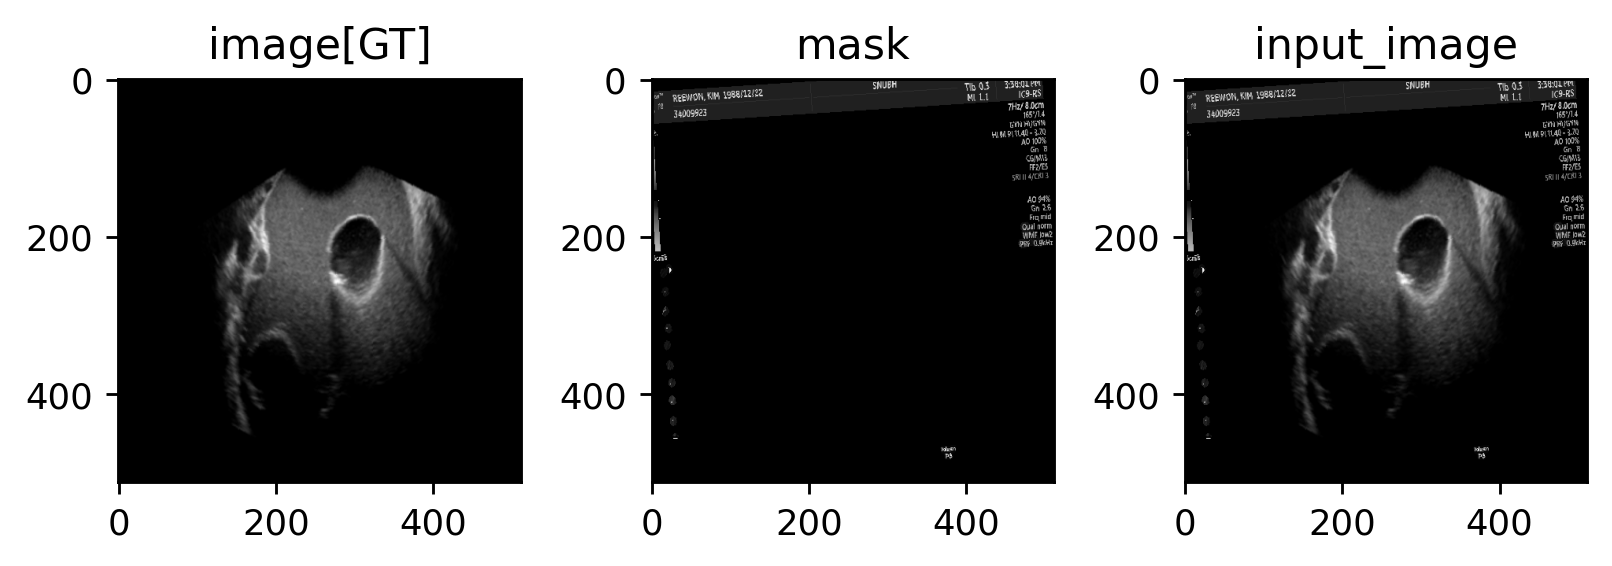

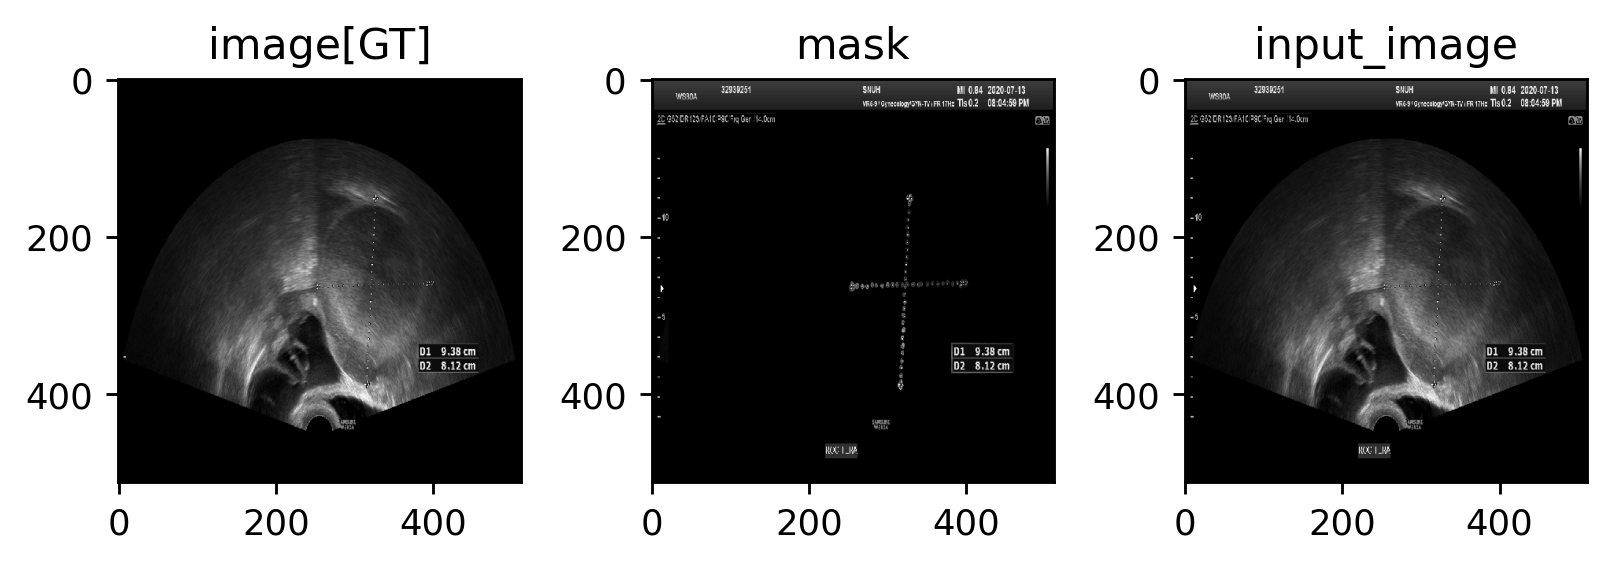

In [12]:
for images, masks in train_loader:
    # mask가 0이 아닌 부분에 대해 image를 mask로 대체
    input_images = images.clone()
    # mask와 input_images shape이 같아야하므로 mask를 image shape으로 resize
    print(images.shape, masks.shape)
    input_images[masks != 0] = masks[masks != 0] 
    # input_images 처리해줫으니 다시 masks를 1채널로 변경
    masks = masks[:,0,:,:].unsqueeze(1)

    plotting(images, masks, input_images)
    break
for images, masks, paths in valid_loader:
    # mask가 0이 아닌 부분에 대해 image를 mask로 대체
    input_images = images.clone()
    # mask와 input_images shape이 같아야하므로 mask를 image shape으로 resize
    input_images[masks != 0] = masks[masks != 0] 
        
    # input_images 처리해줫으니 다시 masks를 1채널로 변경
    masks = masks[:,0,:,:].unsqueeze(1)
    plotting(images, masks, input_images)
    break


In [13]:
from model import VAE

input_dim = 4
hidden_dim =512
latent_dim = 32
n_embeddings = 512
output_dim = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = VAE.Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)
codebook = VAE.VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim)
decoder = VAE.Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = VAE.Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(device)

In [14]:
from torchsummary import summary
from loss.loss import L1, Perceptual, Style, smgan 
import torch.optim as optim
import torch


optimizer= optim.Adam(params= model.parameters(), lr = 0.0001, betas = (0, 0.9))
mse_loss = nn.MSELoss()

metrics = {
    'train_losses':[],
    'valid_losses':[],
}

In [15]:
def save_validation(labels, masks, input_images, pred_images, pred_masks, comp_images,  epoch, save_dir):
    plt.figure(dpi=128)
    plt.subplot(231)
    plt.imshow(labels[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.title("original")
    plt.subplot(232)
    plt.imshow(masks[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.title("mask")
    plt.subplot(233)
    plt.imshow(input_images[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.title('input image')
    plt.subplot(234)
    plt.imshow(pred_images[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.title('pred before image')
    plt.subplot(235)
    plt.imshow(pred_masks[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.title('pred Discriminator mask')
    plt.subplot(236)
    plt.imshow(comp_images[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.title('Result image')
    plt.tight_layout()
    # plt.savefig(os.path.join(save_dir, f'epoch_{epoch}.png'))
    plt.show()
    plt.close()

def save_model(netG, netD, optimG, optimD, epoch, save_dir):
    torch.save({
        'netG': netG.state_dict(),
        'netD': netD.state_dict(),
        'optimG': optimG.state_dict(),
        'optimD': optimD.state_dict()
    }, os.path.join(save_dir, f'epoch_{epoch}.pt'))

def save_loss(metrics, save_dir):
    # loss plot
    plt.figure(dpi=128)
    for key, value in metrics.items():
        plt.plot(value, label=key)
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'loss.png'))
    plt.close()
    
    np.save(os.path.join(save_dir, 'metrics.npy'),metrics)


In [16]:
save_path = '/mnt/HDD/oci_models/VAE_240505'
os.makedirs(save_path, exist_ok=True)
for epoch in range(30):
    train_losses, valid_losses = 0,0
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        ### 전처리 
        # mask가 0이 아닌 부분에 대해 image를 mask로 대체
        input_images = images.clone()
        # mask와 input_images shape이 같아야하므로 mask를 image shape으로 resize
        input_images[masks != 0] = masks[masks != 0] 

        # input_images 처리해줫으니 다시 masks를 1채널로 변경
        masks = masks[:,0,:,:].unsqueeze(1)
        
        # 입력이미지 device 할당 
        input_images = input_images.to(device) 
    
        ### Training
        pred_images, commitment_loss, codebook_loss, perplexity = model(input_images, masks)
        
        ## mask에서 0이 아닌 부분을 GT로 대체, 이때 마스크는 0~1사이의 값을 가짐 
        masks = masks.repeat(1,3,1,1)
        comp_images = images.clone()
        comp_images[masks != 0] = pred_images[masks != 0]
        masks = masks[:,0,:,:].unsqueeze(1)

        recon_loss = mse_loss(pred_images, images)
        losses =  recon_loss + commitment_loss * 0.25 + codebook_loss
        
        optimizer.zero_grad()
        
        losses.backward()
        
        optimizer.step()
        
        train_losses += losses.cpu().detach().item()
        print(images.shape)
        print(masks.shape)
        print(input_images.shape)
        print(pred_images.shape)
        print(comp_images.shape)
        break 

    with torch.no_grad():
        model.eval()
        for images, masks, paths in valid_loader:
            images, masks = images.to(device), masks.to(device)
            ### 전처리
            # mask가 0이 아닌 부분에 대해 image를 mask로 대체
            input_images = images.clone()
            # mask와 input_images shape이 같아야하므로 mask를 image shape으로 resize
            input_images[masks != 0] = masks[masks != 0] 
            # input_images 처리해줫으니 다시 masks를 1채널로 변경
            masks = masks[:,0,:,:].unsqueeze(1)
            # 입력이미지 device 할당
            input_images = input_images.to(device) 

            ### inference
            pred_images, commitment_loss, codebook_loss, perplexity  = model(input_images, masks)  # 3+1ch
            
            ## mask에서 0이 아닌 부분을 GT로 대체, 이때 마스크는 0~1사이의 값을 가짐 
            masks = masks.repeat(1,3,1,1)
            comp_images = images.clone()
            comp_images[masks != 0] = pred_images[masks != 0]
            masks = masks[:,0,:,:].unsqueeze(1)


            recon_loss = mse_loss(pred_images, images)
            losses =  recon_loss + commitment_loss * 0.25 + codebook_loss

            valid_losses += losses.cpu().detach().item()
            break
    if epoch % 5 == 0:
        plt.figure(dpi = 128)
        plt.subplot(221)
        plt.imshow(input_images[1,0].cpu().detach().numpy(), cmap= 'gray')
        plt.title('Input Image')
        plt.subplot(222)
        plt.imshow(masks[1,0].cpu().detach().numpy(), cmap= 'gray')
        plt.title('mask')
        plt.subplot(223)
        plt.imshow(pred_images[1,0].cpu().detach().numpy(), cmap= 'gray')
        plt.title('Pred_image')
        plt.subplot(223)
        plt.imshow(comp_images[1,0].cpu().detach().numpy(), cmap= 'gray')
        plt.title('Result image')
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, f'epoch_{epoch}.png'))
        # plt.show()
        plt.close()

    metrics['train_losses'].append(train_losses / len(train_loader))
    metrics['valid_losses'].append(valid_losses / len(valid_loader))

    print("#" * 100)    
    print(f"Train -LOSSES : {metrics['train_losses'][-1]} \n")
    print(f"Valid -LOSSES : {metrics['valid_losses'][-1]} \n")
    print("#" * 100)
    


torch.Size([6, 3, 512, 512])
torch.Size([6, 1, 512, 512])
torch.Size([6, 3, 512, 512])
torch.Size([6, 3, 512, 512])
torch.Size([6, 3, 512, 512])
####################################################################################################
Train -LOSSES : 0.0001764931056621301 

Valid -LOSSES : 0.00015013535385546476 

####################################################################################################
torch.Size([6, 3, 512, 512])
torch.Size([6, 1, 512, 512])
torch.Size([6, 3, 512, 512])
torch.Size([6, 3, 512, 512])
torch.Size([6, 3, 512, 512])
####################################################################################################
Train -LOSSES : 0.00012764222285463283 

Valid -LOSSES : 0.00014044437189347187 

####################################################################################################
torch.Size([6, 3, 512, 512])
torch.Size([6, 1, 512, 512])
torch.Size([6, 3, 512, 512])
torch.Size([6, 3, 512, 512])
torch.Size([6, 3, 512, 512]